#**Maestría en Inteligencia Artificial Aplicada**
##**Curso: Análisis de Grandes Volúmenes de Datos**
###Tecnológico de Monterrey
###Prof. Iván Olmos

## **Actividad Semana 03**

###**Proyecto: Base de Datos de Big Data**

##### Nombres y matrículas de los integrantes del equipo:
*   Victoria Melgarejo Cabrera - A01795030
*   Héctor Alejandro Alvarez Rosas        - A01796262
*   Andrea Xcaret Gomez Alfaro        - A01796384
*   Mario Guillen De La Torre       - A01796701


---


#### **Descripción de la Actividad:**

Identificar una base de datos de big data para la aplicación de los conceptos aprendidos en el curso, iniciando con la manipulación básica de lectura y escritura de archivos con PySpark.



---

In [20]:
# Instalación de PySpark en Colab
!pip install pyspark

### **Importación de Librerías**

In [21]:
from pyspark.sql import SparkSession, Row
from pyspark.sql.types import StructType, StructField, StringType, LongType, DoubleType
from pyspark.sql.functions import col, isnan, when, count, lit, percentile_approx, hour, dayofweek, unix_timestamp, mean, stddev, min, max, desc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as stats

In [22]:
# Función auxiliar de visualización
from IPython.display import display, HTML

def prettyDisplay(df, limit=1000):
    """
    Convierte un PySpark DataFrame a Pandas y lo muestra como una tabla HTML con scroll horizontal.
    
    Args:
        df (pyspark.sql.DataFrame): El DataFrame de PySpark a mostrar.
        limit (int): Número máximo de filas a mostrar. Por defecto 1000.
    """
    pdf = df.limit(limit).toPandas()
    display(HTML(pdf.to_html(notebook=True)))

### **Creación de la Sesión Spark**

In [23]:
spark = SparkSession.builder \
    .appName("ChicagoTaxyTripsAnalysis") \
    .getOrCreate()

# Hide errors
spark.sparkContext.setLogLevel("ERROR")

### **Carga del Dataset**

In [24]:
filename = "Taxi_Trips.csv"

dftaxytrips = spark.read.csv(filename, header=True, inferSchema=True)

In [25]:
print("Número de registros:", dftaxytrips.count())
print("Número de columnas:", len(dftaxytrips.columns))

[Stage 343:===================================>                   (16 + 8) / 25]

Número de registros: 7917844
Número de columnas: 23


### **Exploración de los Datos**

In [26]:
# Estructura del dataset
dftaxytrips.printSchema()

root
 |-- Trip ID: string (nullable = true)
 |-- Taxi ID: string (nullable = true)
 |-- Trip Start Timestamp: string (nullable = true)
 |-- Trip End Timestamp: string (nullable = true)
 |-- Trip Seconds: integer (nullable = true)
 |-- Trip Miles: double (nullable = true)
 |-- Pickup Census Tract: long (nullable = true)
 |-- Dropoff Census Tract: long (nullable = true)
 |-- Pickup Community Area: integer (nullable = true)
 |-- Dropoff Community Area: integer (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Tips: double (nullable = true)
 |-- Tolls: double (nullable = true)
 |-- Extras: double (nullable = true)
 |-- Trip Total: double (nullable = true)
 |-- Payment Type: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- Pickup Centroid Latitude: double (nullable = true)
 |-- Pickup Centroid Longitude: double (nullable = true)
 |-- Pickup Centroid Location: string (nullable = true)
 |-- Dropoff Centroid Latitude: double (nullable = true)
 |-- Dropoff Centroid 

In [27]:
# Primeras filas
# dftaxytrips.show(5)
prettyDisplay(dftaxytrips, 5)

,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,Fare,Tips,Tolls,Extras,Trip Total,Payment Type,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location
0,0000184e7cd53cee95af32eba49c44e4d20adcd8,f538e6b729d1aaad4230e9dcd9dc2fd9a168826ddadbd6...,01/19/2024 05:00:00 PM,01/19/2024 06:00:00 PM,4051,17.12,1.703198e+10,1.703132e+10,76,32.0,45.50,10.00,0.0,4.0,60.00,Credit Card,Flash Cab,41.979071,-87.903040,POINT (-87.9030396611 41.9790708201),41.884987,-87.620993,POINT (-87.6209929134 41.8849871918)
1,000072ee076c9038868e239ca54185eb43959db0,e51e2c30caec952b40b8329a68b498e18ce8a1f40fa75c...,01/28/2024 02:30:00 PM,01/28/2024 03:00:00 PM,1749,12.70,NaN,NaN,6,NaN,33.75,0.00,0.0,0.0,33.75,Cash,Flash Cab,41.944227,-87.655998,POINT (-87.6559981815 41.9442266014),NaN,NaN,None
2,000074019d598c2b1d6e77fbae79e40b0461a2fc,aeb280ef3be3e27e081eb6e76027615b0d40925b84d3eb...,01/05/2024 09:00:00 AM,01/05/2024 09:00:00 AM,517,3.39,NaN,NaN,6,8.0,10.91,2.78,0.0,1.0,14.69,Mobile,Taxicab Insurance Agency Llc,41.944227,-87.655998,POINT (-87.6559981815 41.9442266014),41.899602,-87.633308,POINT (-87.6333080367 41.899602111)
3,00007572c5f92e2ff067e6f838a5ad74e83665d3,7d21c2ca227db8f27dda96612bfe5520ab408fa9a462c8...,01/22/2024 08:45:00 AM,01/22/2024 09:30:00 AM,2050,15.06,NaN,NaN,76,NaN,39.25,11.31,0.0,5.5,56.56,Credit Card,Globe Taxi,41.980264,-87.913625,POINT (-87.913624596 41.9802643146),NaN,NaN,None
4,00007c3e7546e2c7d15168586943a9c22c3856cf,8ef1056519939d511d24008e394f83e925d2539d668a00...,01/18/2024 07:15:00 PM,01/18/2024 07:30:00 PM,1004,1.18,1.703184e+10,1.703184e+10,32,32.0,15.94,3.72,0.0,0.0,19.66,Mobile,5 Star Taxi,41.880994,-87.632746,POINT (-87.6327464887 41.8809944707),41.880994,-87.632746,POINT (-87.6327464887 41.8809944707)


In [28]:
# dftaxytrips.summary().show()
prettyDisplay(dftaxytrips.summary())

,summary,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,Fare,Tips,Tolls,Extras,Trip Total,Payment Type,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location
0,count,7917844,7917844,7917844,7917778,7916303,7917775,3392900,3281682,7691067,7174891,7897269,7897269,7897269,7897269,7897269,7917844,7917844,7695376,7695376,7695376,7220191,7220191,7220191
1,mean,Infinity,None,None,None,1254.9250153764958,6.802327488467674,1.7031508395342648E10,1.703141394138261E10,36.09328575605959,26.293705646538744,22.89300292290886,2.9030046741474513,0.029434495646532992,2.1529685008830275,28.182303074643663,None,None,41.901399650735996,-87.7019076253514,None,41.8921376218955,-87.66080016228891,None
2,stddev,None,None,None,None,1648.0977197601726,7.957195844290252,374237.3662004645,342509.8545557547,26.291497670579886,20.81465342793271,33.2323786885119,4.284313925861233,5.0707919401752175,10.395597618506331,38.30632012119162,None,None,0.06525246745369662,0.11455514438305599,None,0.05843544231278496,0.07200598932628444,None
3,min,0000006aa752d456d05c6eeb43b057adb1ffa540,000daaa11a2d961100513e232a1ce05391c5d797d2dc56...,01/01/2024 01:00:00 AM,01/01/2024 01:00:00 AM,0,0.0,17031010100,17031010100,1,1,0.0,0.0,0.0,0.0,0.0,Cash,2733 - 74600 Benny Jona,41.650221676,-87.913624596,POINT (-87.5307124836 41.7030053028),41.650221676,-87.913624596,POINT (-87.5349029012 41.707311449)
4,25%,Infinity,None,None,None,480,1.03,17031081700,17031081500,8,8,8.5,0.0,0.0,0.0,10.25,None,None,41.878865584,-87.750934289,None,41.878865584,-87.66351755,None
5,50%,Infinity,None,None,None,943,3.34,17031320400,17031320100,32,28,16.0,0.57,0.0,0.0,19.22,None,None,41.89503345,-87.642648998,None,41.892042136,-87.633308037,None
6,75%,Infinity,None,None,None,1714,11.98,17031980000,17031839100,63,32,34.5,4.0,0.0,2.25,43.22,None,None,41.97907082,-87.625192142,None,41.922686284,-87.625192142,None
7,max,ffffffdda8f2f9f98cf474cce05b7e5e34dc25e4,ffda53354c610fd3af1aee46d723028a49014e35f7280c...,12/31/2024 12:45:00 PM,12/31/2024 12:45:00 PM,86396,3397.8,17031980100,17031980100,77,77,9999.75,400.0,5550.0,5559.5,9999.75,Unknown,Wolley Taxi,42.021223593,-87.530712484,POINT (-87.913624596 41.9802643146),42.021223593,-87.534902901,POINT (-87.913624596 41.9802643146)


In [29]:
# Estadísticas generales
# dftaxytrips.describe().show()
prettyDisplay(dftaxytrips.describe())

,summary,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,Fare,Tips,Tolls,Extras,Trip Total,Payment Type,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location
0,count,7917844,7917844,7917844,7917778,7916303,7917775,3392900,3281682,7691067,7174891,7897269,7897269,7897269,7897269,7897269,7917844,7917844,7695376,7695376,7695376,7220191,7220191,7220191
1,mean,Infinity,None,None,None,1254.9250153764958,6.802327488467674,1.7031508395342648E10,1.703141394138261E10,36.09328575605959,26.293705646538744,22.89300292290886,2.9030046741474513,0.029434495646532992,2.1529685008830275,28.182303074643663,None,None,41.901399650735996,-87.7019076253514,None,41.8921376218955,-87.66080016228891,None
2,stddev,None,None,None,None,1648.0977197601726,7.957195844290252,374237.3662004645,342509.8545557547,26.291497670579886,20.81465342793271,33.2323786885119,4.284313925861233,5.0707919401752175,10.395597618506331,38.30632012119162,None,None,0.06525246745369662,0.11455514438305599,None,0.05843544231278496,0.07200598932628444,None
3,min,0000006aa752d456d05c6eeb43b057adb1ffa540,000daaa11a2d961100513e232a1ce05391c5d797d2dc56...,01/01/2024 01:00:00 AM,01/01/2024 01:00:00 AM,0,0.0,17031010100,17031010100,1,1,0.0,0.0,0.0,0.0,0.0,Cash,2733 - 74600 Benny Jona,41.650221676,-87.913624596,POINT (-87.5307124836 41.7030053028),41.650221676,-87.913624596,POINT (-87.5349029012 41.707311449)
4,max,ffffffdda8f2f9f98cf474cce05b7e5e34dc25e4,ffda53354c610fd3af1aee46d723028a49014e35f7280c...,12/31/2024 12:45:00 PM,12/31/2024 12:45:00 PM,86396,3397.8,17031980100,17031980100,77,77,9999.75,400.0,5550.0,5559.5,9999.75,Unknown,Wolley Taxi,42.021223593,-87.530712484,POINT (-87.913624596 41.9802643146),42.021223593,-87.534902901,POINT (-87.913624596 41.9802643146)


In [30]:
# Análisis de valores únicos

unique_values = []

# Recorremos cada columna y guardamos info
for col_name in dftaxytrips.columns:
    distinct_count = dftaxytrips.select(col_name).distinct().count()
    data_type = [f.dataType for f in dftaxytrips.schema.fields if f.name == col_name][0]
    
    unique_values.append(Row(Columna=col_name, TipoDato=str(data_type), ValoresUnicos=distinct_count))

# Creamos un nuevo DataFrame con los resultados
unique_df = spark.createDataFrame(unique_values)

# Mostramos la tabla ordenada por número de valores únicos
prettyDisplay(unique_df.orderBy("ValoresUnicos", ascending=False))

,Columna,TipoDato,ValoresUnicos
0,Trip ID,StringType(),7917844
1,Trip End Timestamp,StringType(),43785
2,Trip Start Timestamp,StringType(),43769
3,Trip Seconds,IntegerType(),17001
4,Trip Total,DoubleType(),15840
5,Fare,DoubleType(),10170
6,Trip Miles,DoubleType(),7720
7,Tips,DoubleType(),3733
8,Extras,DoubleType(),3513
9,Taxi ID,StringType(),3409


In [31]:
# Lista para guardar los resultados
missing_data = []

# Recorremos cada columna
for c in dftaxytrips.columns:
    null_count = dftaxytrips.filter(col(c).isNull() | isnan(c)).count()
    null_percent = (null_count / dftaxytrips.count()) * 100
    missing_data.append(Row(Columna=c, Faltantes=null_count, Porcentaje=round(null_percent, 2)))

# Creamos un nuevo DataFrame
missing_df = spark.createDataFrame(missing_data)

# Ordenamos de mayor a menor según porcentaje
prettyDisplay(missing_df.orderBy("Porcentaje", ascending=False))

,Columna,Faltantes,Porcentaje
0,Dropoff Census Tract,4636162,58.55
1,Pickup Census Tract,4524944,57.15
2,Dropoff Community Area,742953,9.38
3,Dropoff Centroid Latitude,697653,8.81
4,Dropoff Centroid Longitude,697653,8.81
5,Dropoff Centroid Location,697653,8.81
6,Pickup Community Area,226777,2.86
7,Pickup Centroid Latitude,222468,2.81
8,Pickup Centroid Longitude,222468,2.81
9,Pickup Centroid Location,222468,2.81


Vemos que las columnas Dropoff Census Tract y Pickup Census Tract las podemos eliminar, ya que contienen una gran cantidad de valores faltantas y no son variables que nos interesen tener en el análisis. Es decir, no serán consideradas como variables de caracterización.

In [32]:
categoric_cols = [
    "Trip ID",
    "Taxi ID",
    "Trip Start Timestamp",
    "Trip End Timestamp",
    "Payment Type",
    "Company",
    "Pickup Centroid Location",
    "Dropoff Centroid  Location"
]
numeric_cols = [
    "Trip Seconds",
    "Trip Miles",
    "Pickup Census Tract",
    "Dropoff Census Tract",
    "Pickup Community Area",
    "Dropoff Community Area",
    "Fare",
    "Tips",
    "Tolls",
    "Extras",
    "Trip Total",
    "Pickup Centroid Latitude",
    "Pickup Centroid Longitude",
    "Dropoff Centroid Latitude",
    "Dropoff Centroid Longitude"
]

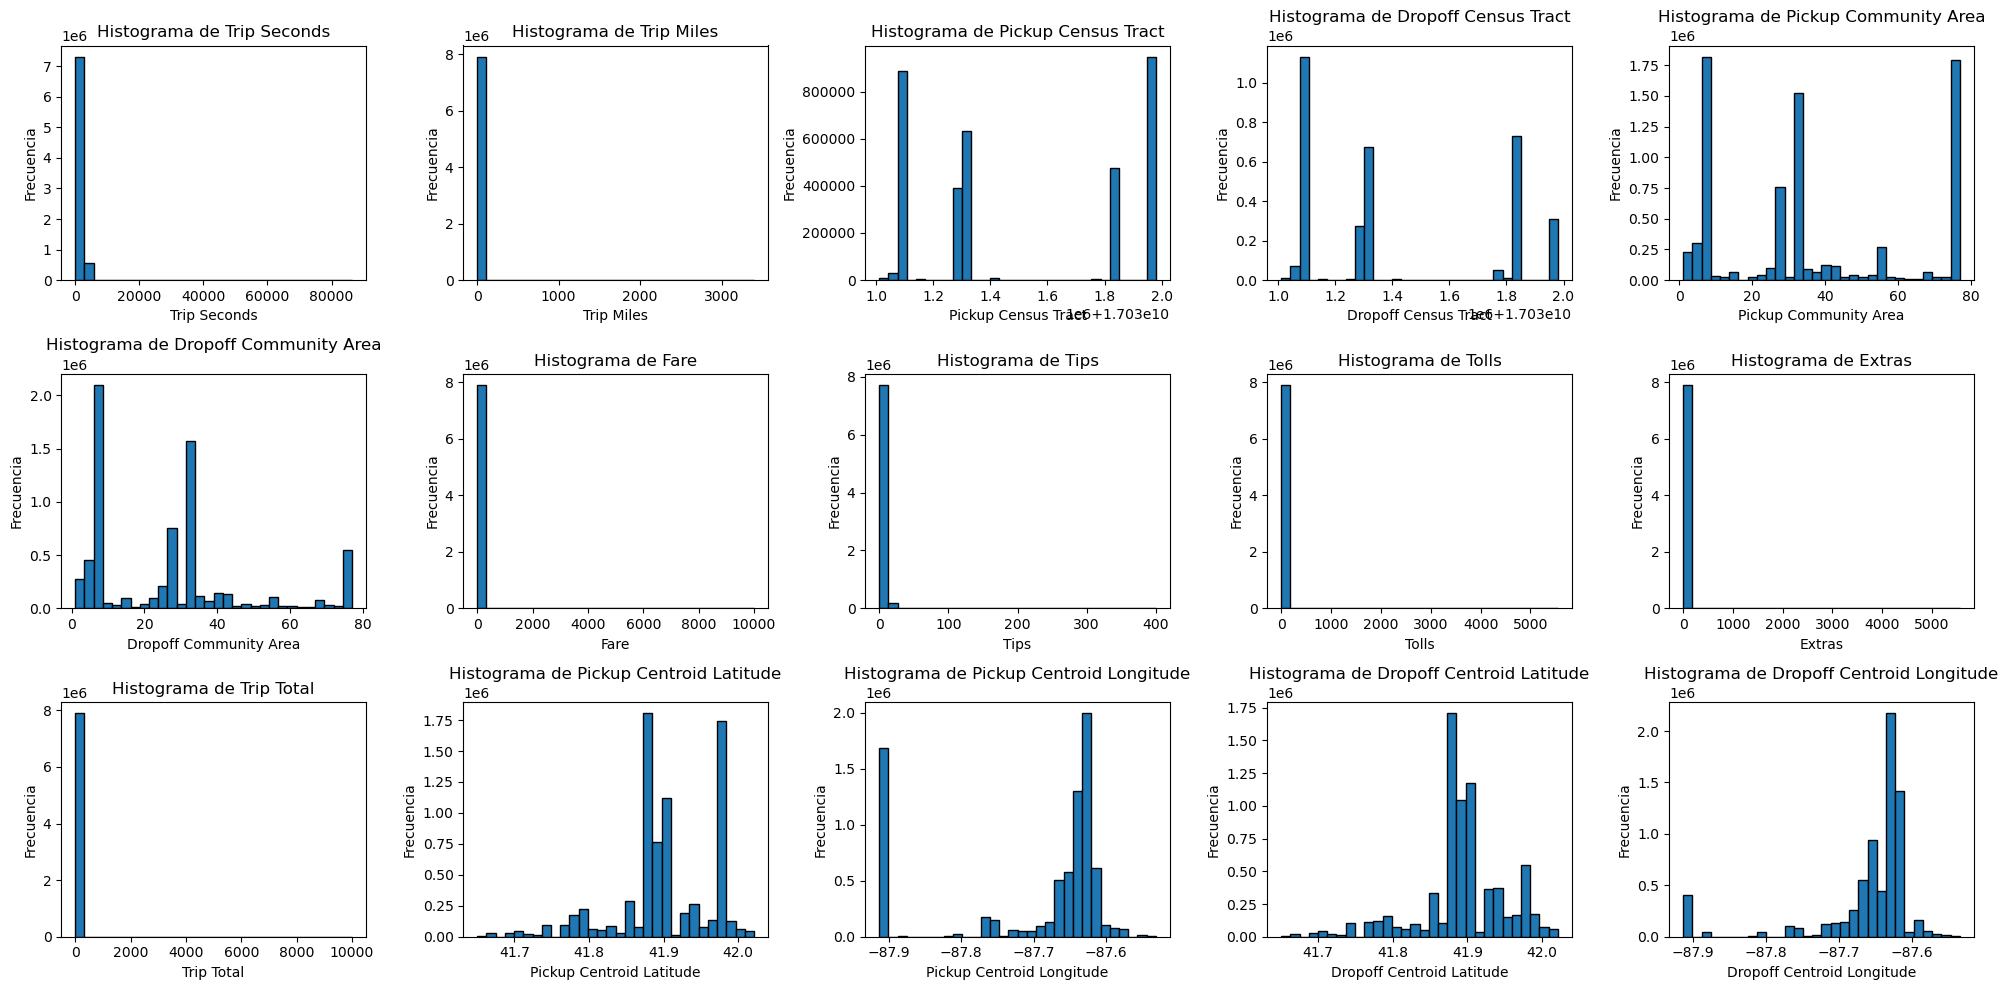

In [33]:
# Graficar histogramas 
plt.figure(figsize=(20, 10))
for i, column in enumerate(numeric_cols, 1):
    # Obtener los datos de la columna después de eliminar los valores atípicos
    data = dftaxytrips.select(column).dropna().rdd.flatMap(lambda x: x).collect()

    # Graficar el histograma
    plt.subplot(3, 5, i)
    plt.hist(data, bins=30, edgecolor='black')
    plt.title(f"Histograma de {column}")
    plt.xlabel(column)
    plt.ylabel("Frecuencia")

plt.tight_layout()
plt.show()

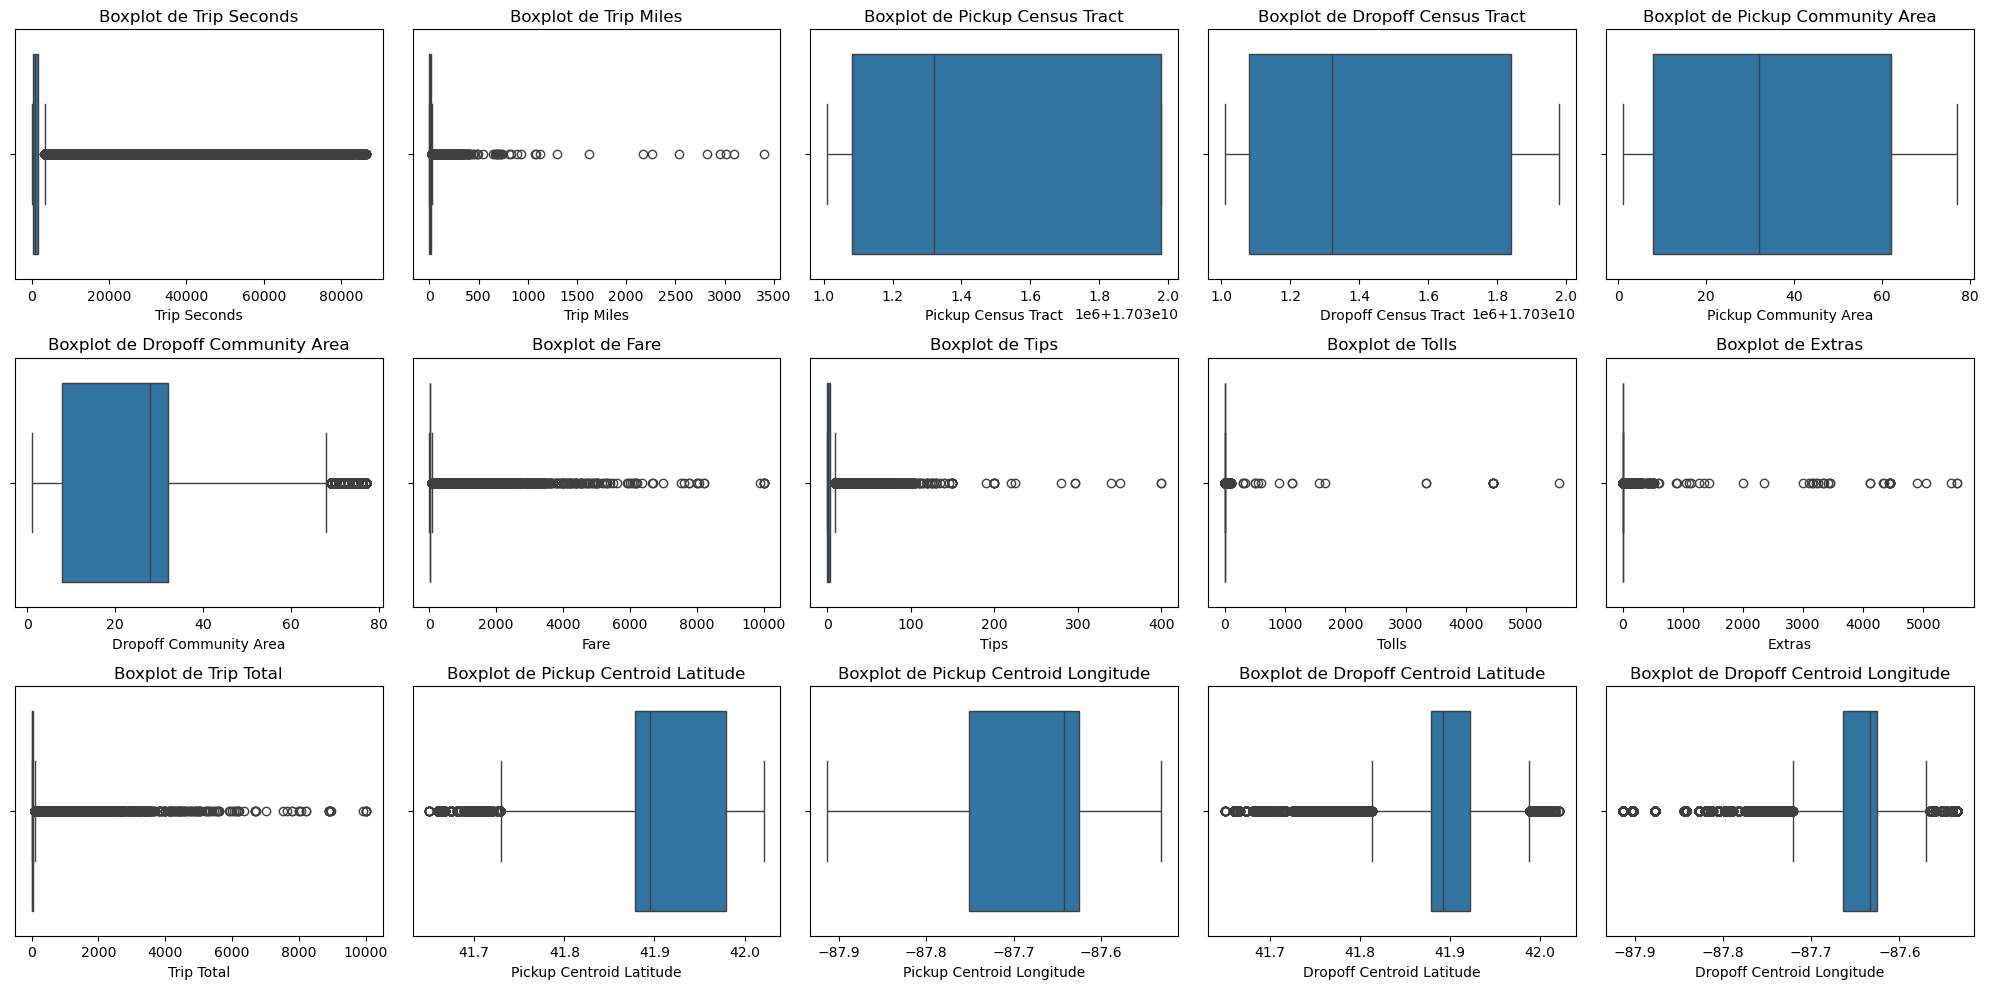

In [34]:
# Graficar los boxplots
plt.figure(figsize=(20, 10))
for i, column in enumerate(numeric_cols, 1):
    # Obtener los datos de la columna
    data = dftaxytrips.select(column).dropna().rdd.flatMap(lambda x: x).collect()

    # Graficar el boxplot
    plt.subplot(3, 5, i)
    sns.boxplot(x=data)
    plt.title(f"Boxplot de {column}")
    plt.xlabel(column)

plt.tight_layout()
plt.show()

/var/folders/_f/_6tlx7c13c37kj_7y13098dr0000gn/T/ipykernel_31924/3654668573.py:26: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


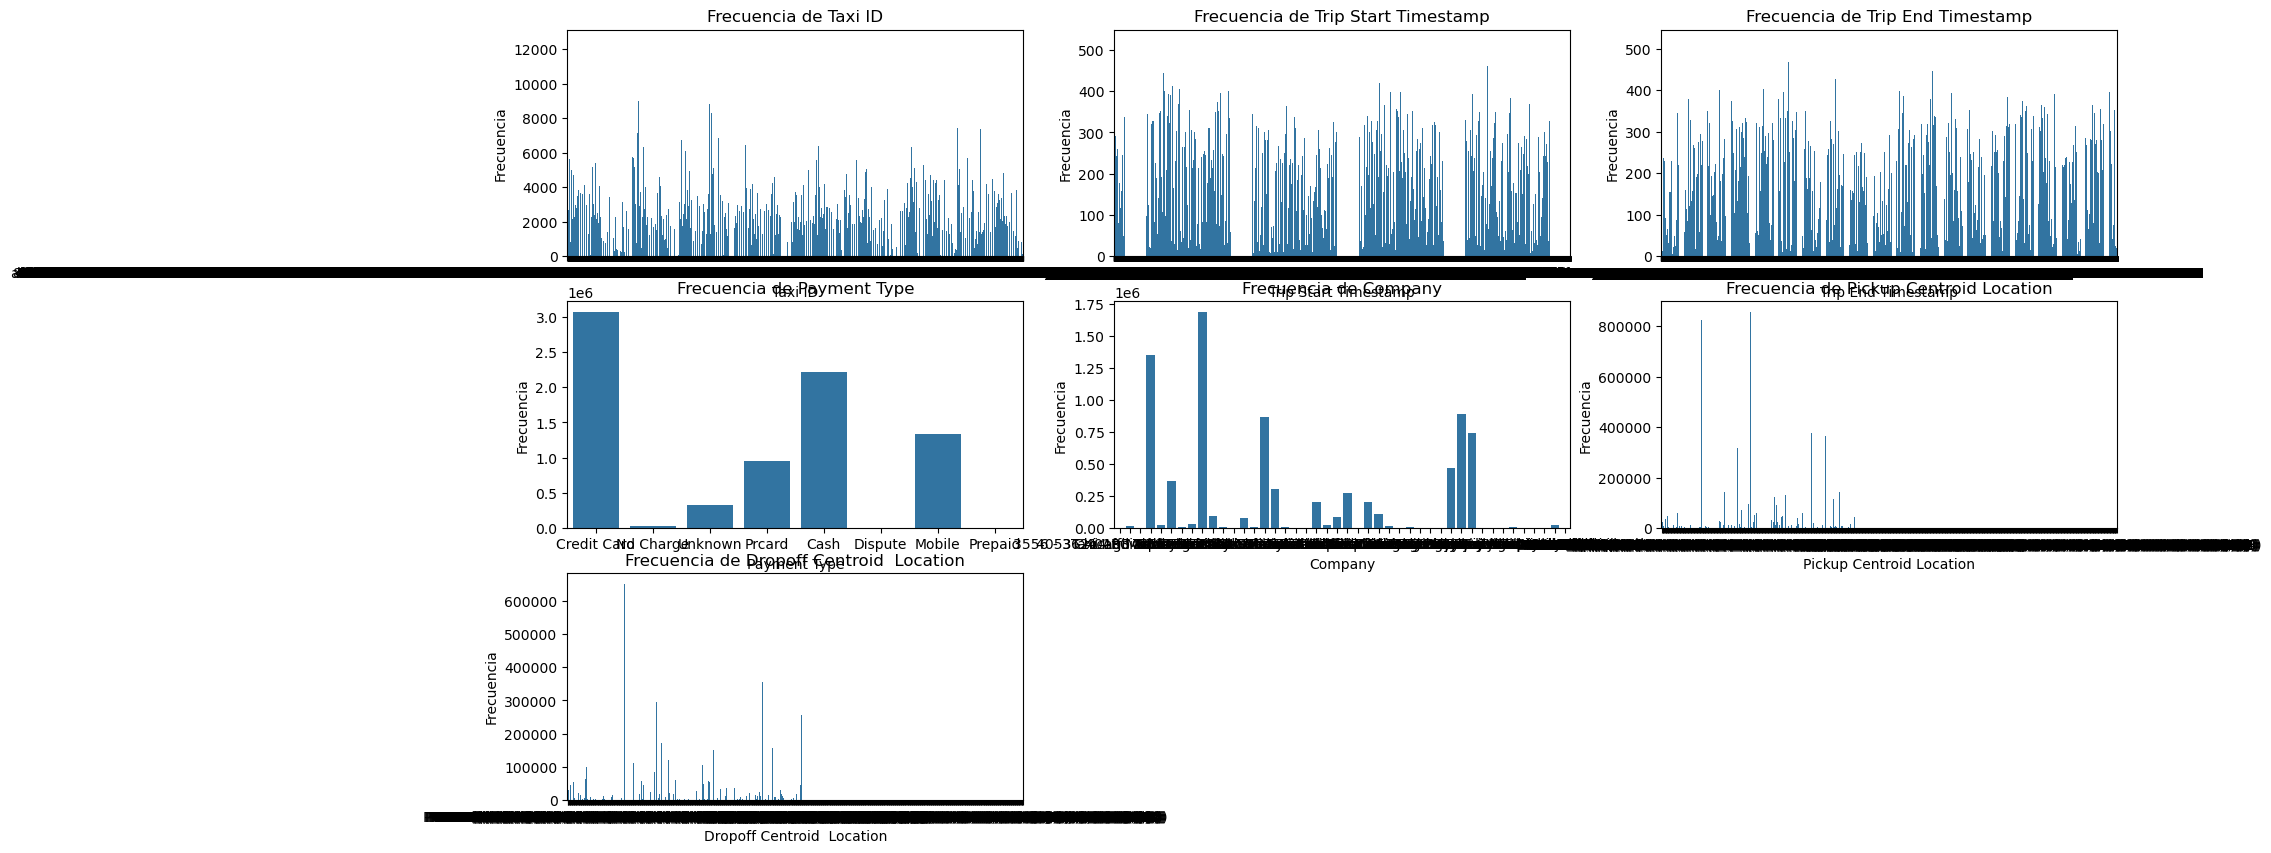

In [35]:
categoric_cols_to_plot = [
    # "Trip ID", // Id único por registro, no es necesario gráficar.
    "Taxi ID",
    "Trip Start Timestamp",
    "Trip End Timestamp",
    "Payment Type",
    "Company",
    "Pickup Centroid Location",
    "Dropoff Centroid  Location"
]
# Visualización de los valores de las columnas categóricas
plt.figure(figsize=(20, 10))

for i, column in enumerate(categoric_cols_to_plot, 1):
    plt.subplot(3, 3, i)
    # Contar las frecuencias de cada categoría
    df_filtered = dftaxytrips.select(column).dropna()  # Eliminar valores nulos
    value_counts = df_filtered.groupBy(column).count().toPandas()

    # Gráfico de barras para cada columna
    sns.barplot(x=column, y="count", data=value_counts)
    plt.title(f"Frecuencia de {column}")
    plt.xlabel(column)
    plt.ylabel("Frecuencia")

plt.tight_layout()
plt.show()

Observamos que existe una gran cantidad de outliers, usaremos la técnica de rango intercuartil para eliminarlos antes de comenzar el análisis.

In [52]:
# Lista de todas las columnas numéricas del DF
all_numeric_cols = [
    "Trip Seconds",
    "Trip Miles",
    "Pickup Census Tract",
    "Dropoff Census Tract",
    "Pickup Community Area",
    "Dropoff Community Area",
    "Fare",
    "Tips",
    "Tolls",
    "Extras",
    "Trip Total",
    "Pickup Centroid Latitude",
    "Pickup Centroid Longitude",
    "Dropoff Centroid Latitude",
    "Dropoff Centroid Longitude"
]
correlation_matrix = {}

for col1 in all_numeric_cols:
    correlation_matrix[col1] = []
    for col2 in all_numeric_cols:
        try:
            corr_value = df_corr.stat.corr(col1, col2)
        except:
            corr_value = 0
        correlation_matrix[col1].append(corr_value)

# DataFrame de Pandas
corr_df = pd.DataFrame(correlation_matrix, index=all_numeric_cols).astype(float)


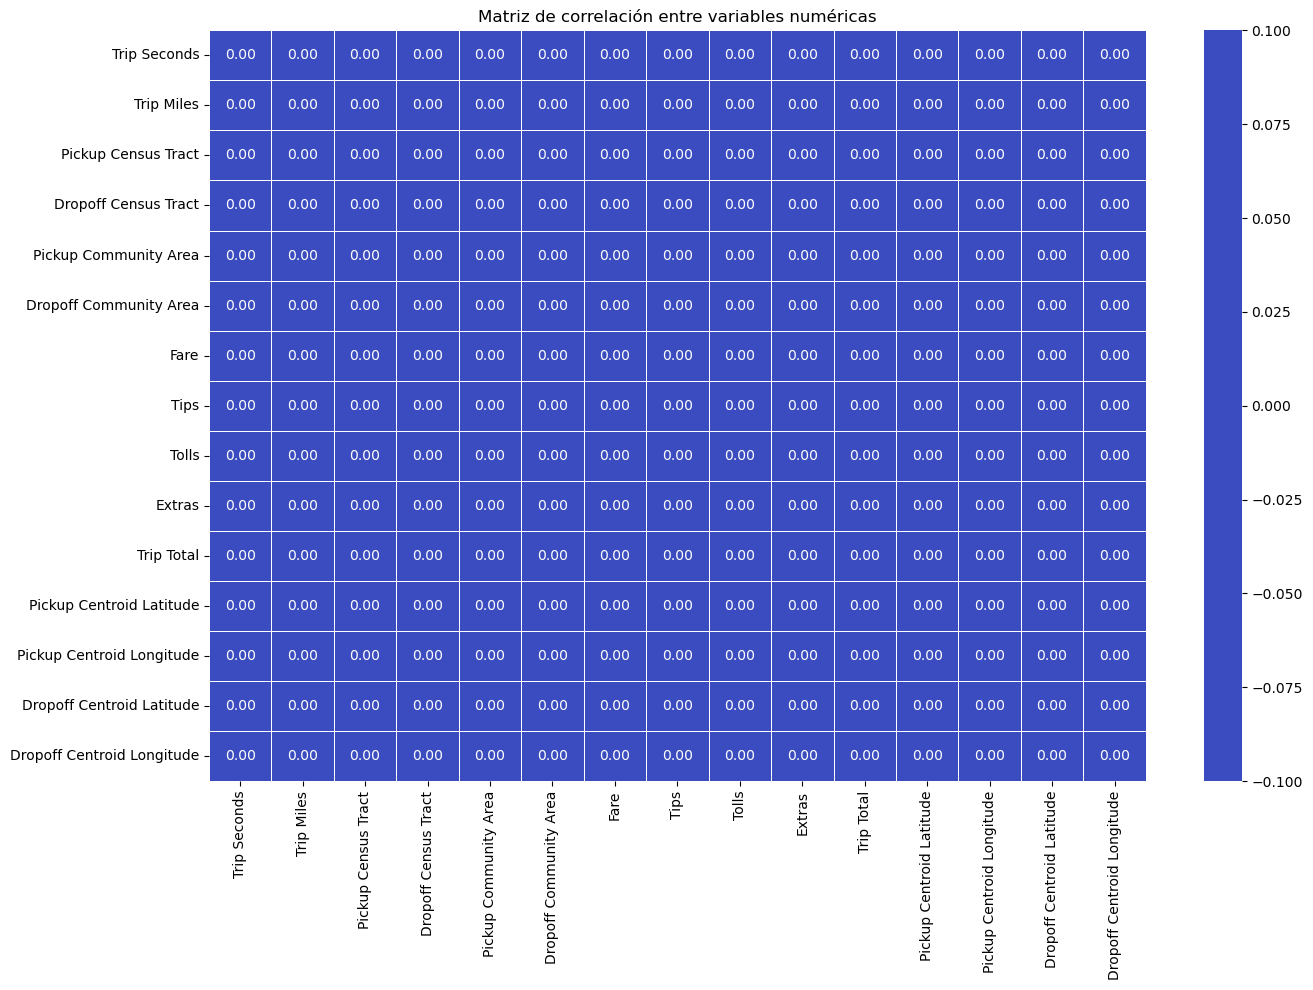

In [53]:
plt.figure(figsize=(14, 10))
sns.heatmap(corr_df, annot=True, fmt=".2f", cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Matriz de correlación entre variables numéricas")
plt.tight_layout()
plt.show()

# Limpieza de datos

In [38]:
# Seleccionamos solo estas variables para el análsis, por tanto quitamos todo lo que no nos sirve.
numeric_cols_selected = [
    "Trip Seconds",
    "Trip Miles",
    "Pickup Community Area",
    "Dropoff Community Area",
    "Fare",
    "Tips",
    "Extras",
    "Trip Total"
]
categoric_cols_selected = [
    "Taxi ID",
    "Trip Start Timestamp",
    "Trip End Timestamp",
    "Payment Type",
    "Company"
]

In [39]:
# Función para eliminar los valores atípicos de un DataFrame y modificarlo
def remove_outliers_inplace(df, column):
    # Calcular los percentiles Q1 y Q3 para la columna
    percentiles = df.approxQuantile(column, [0.25, 0.75], 0.05)  # 5% de error en el cálculo
    Q1 = percentiles[0]
    Q3 = percentiles[1]

    # Calcular el IQR
    IQR = Q3 - Q1

    # Definir los límites inferior y superior para los valores atípicos
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR

    # Filtrar el DataFrame para eliminar los valores atípicos y modificar el DataFrame original
    df = df.filter((col(column) >= lower_limit) & (col(column) <= upper_limit))

    return df

In [42]:
# Filtrar solo columnas seleccionadas
df_filtered = dftaxytrips.select(numeric_cols_selected + categoric_cols_selected)

In [43]:
for colname in numeric_cols_selected:
    clean_df = remove_outliers_inplace(df_filtered, colname)

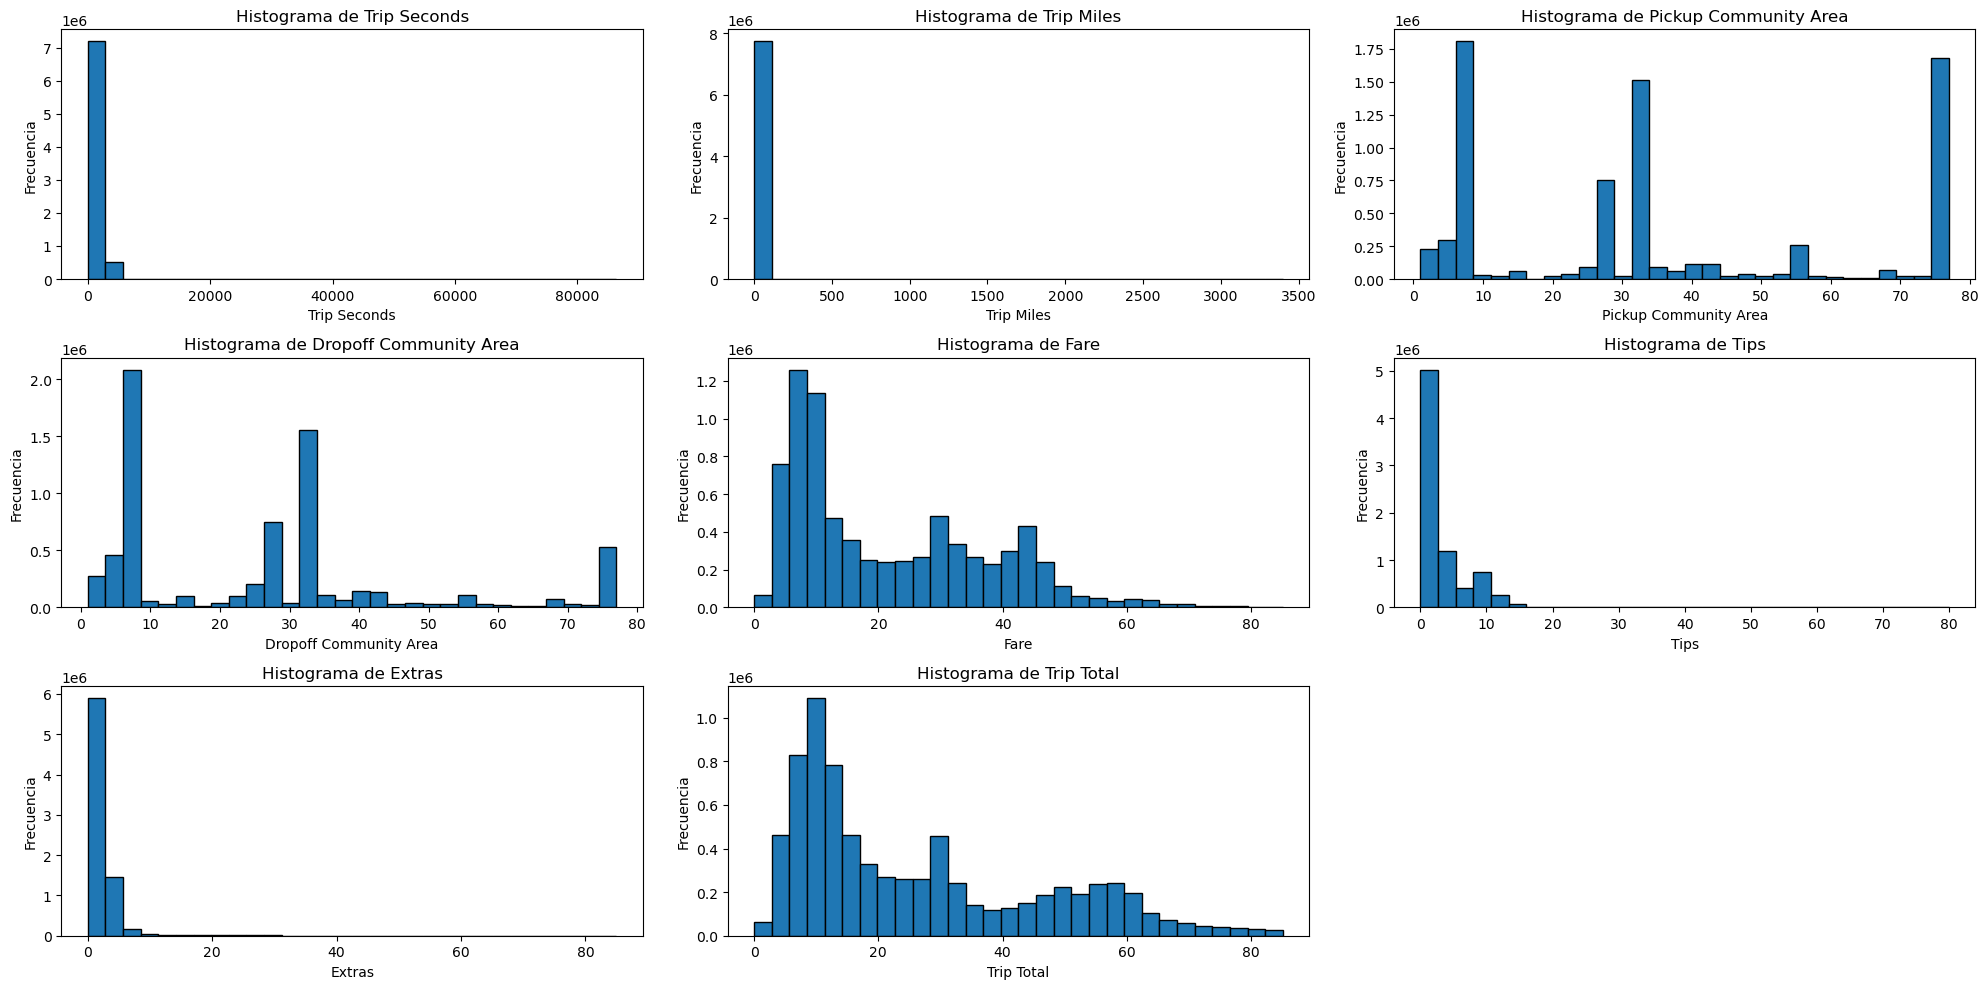

In [44]:
# Graficar histogramas despues de remover outliers
plt.figure(figsize=(20, 10))
for i, column in enumerate(numeric_cols_selected, 1):
    # Obtener los datos de la columna después de eliminar los valores atípicos
    data = clean_df.select(column).dropna().rdd.flatMap(lambda x: x).collect()

    # Graficar el histograma
    plt.subplot(3, 3, i)
    plt.hist(data, bins=30, edgecolor='black')
    plt.title(f"Histograma de {column}")
    plt.xlabel(column)
    plt.ylabel("Frecuencia")

plt.tight_layout()
plt.show()

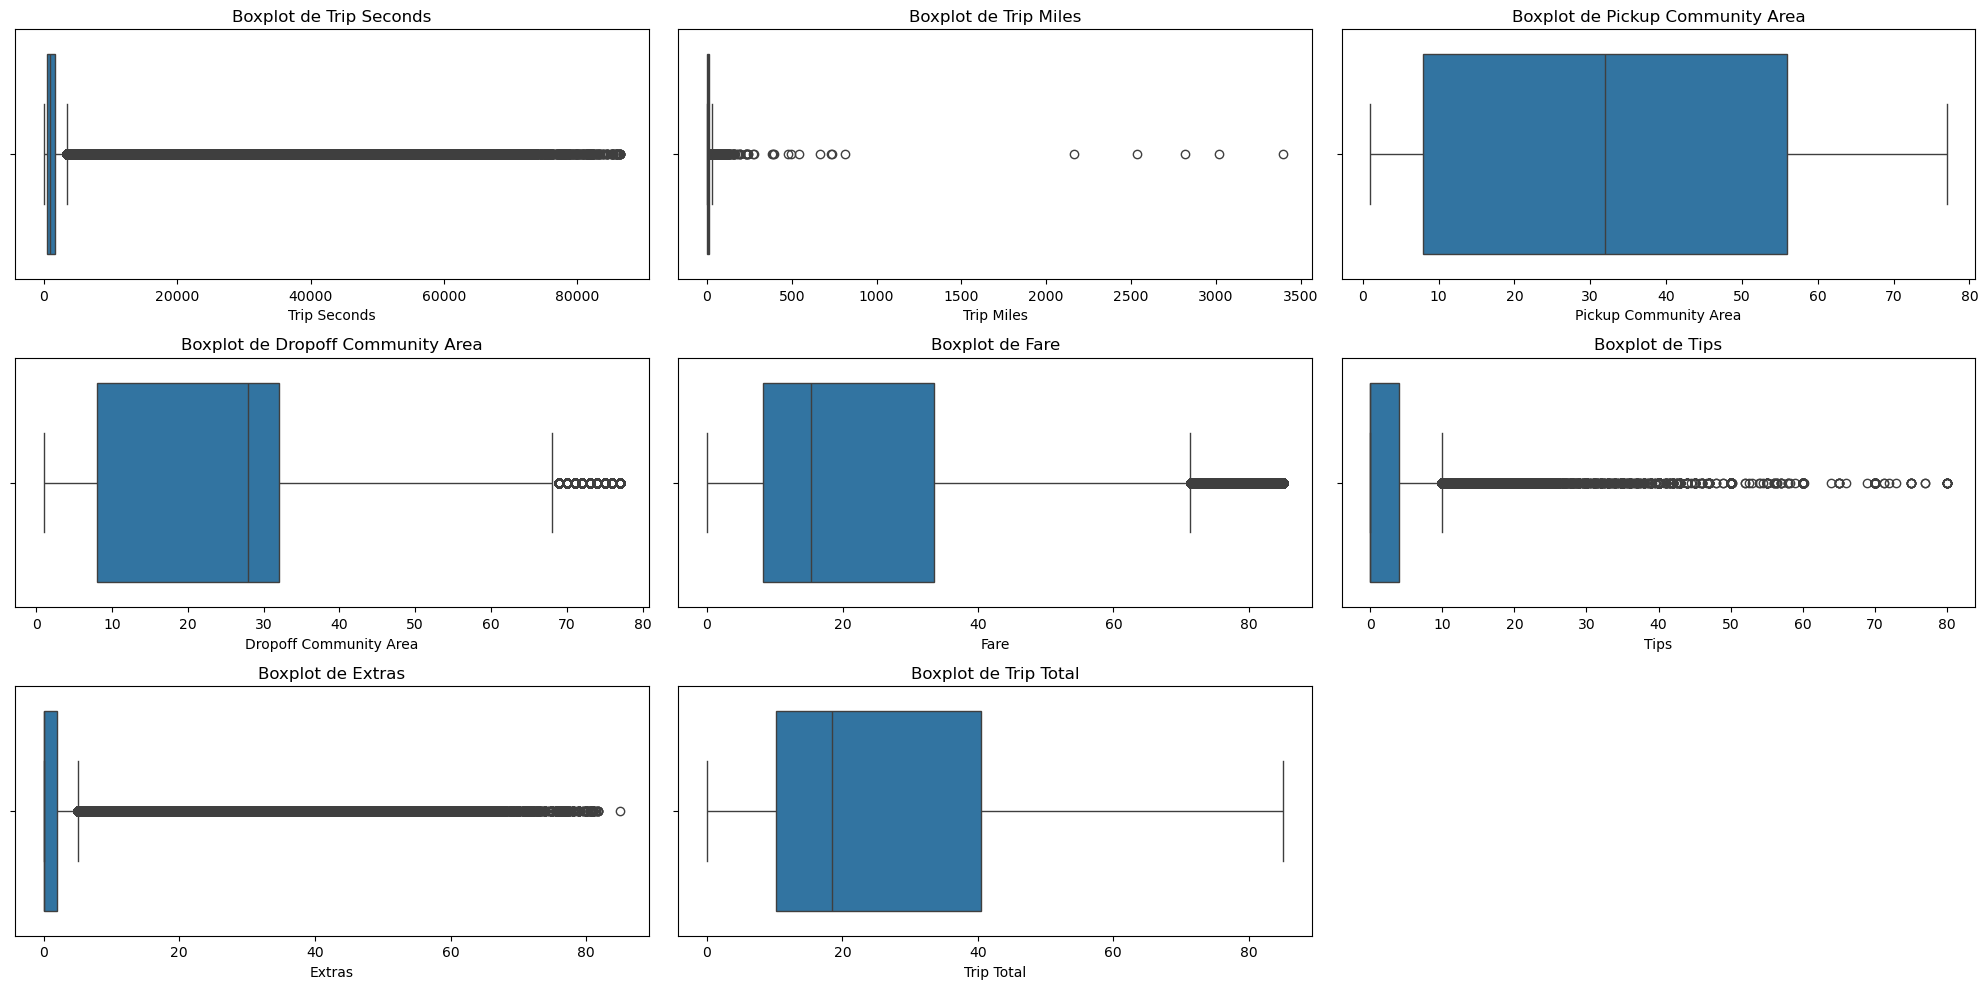

In [45]:
# Graficar los boxplots
plt.figure(figsize=(20, 10))
for i, column in enumerate(numeric_cols_selected, 1):
    # Obtener los datos de la columna
    data = clean_df.select(column).dropna().rdd.flatMap(lambda x: x).collect()

    # Graficar el boxplot
    plt.subplot(3, 3, i)
    sns.boxplot(x=data)
    plt.title(f"Boxplot de {column}")
    plt.xlabel(column)

plt.tight_layout()
plt.show()

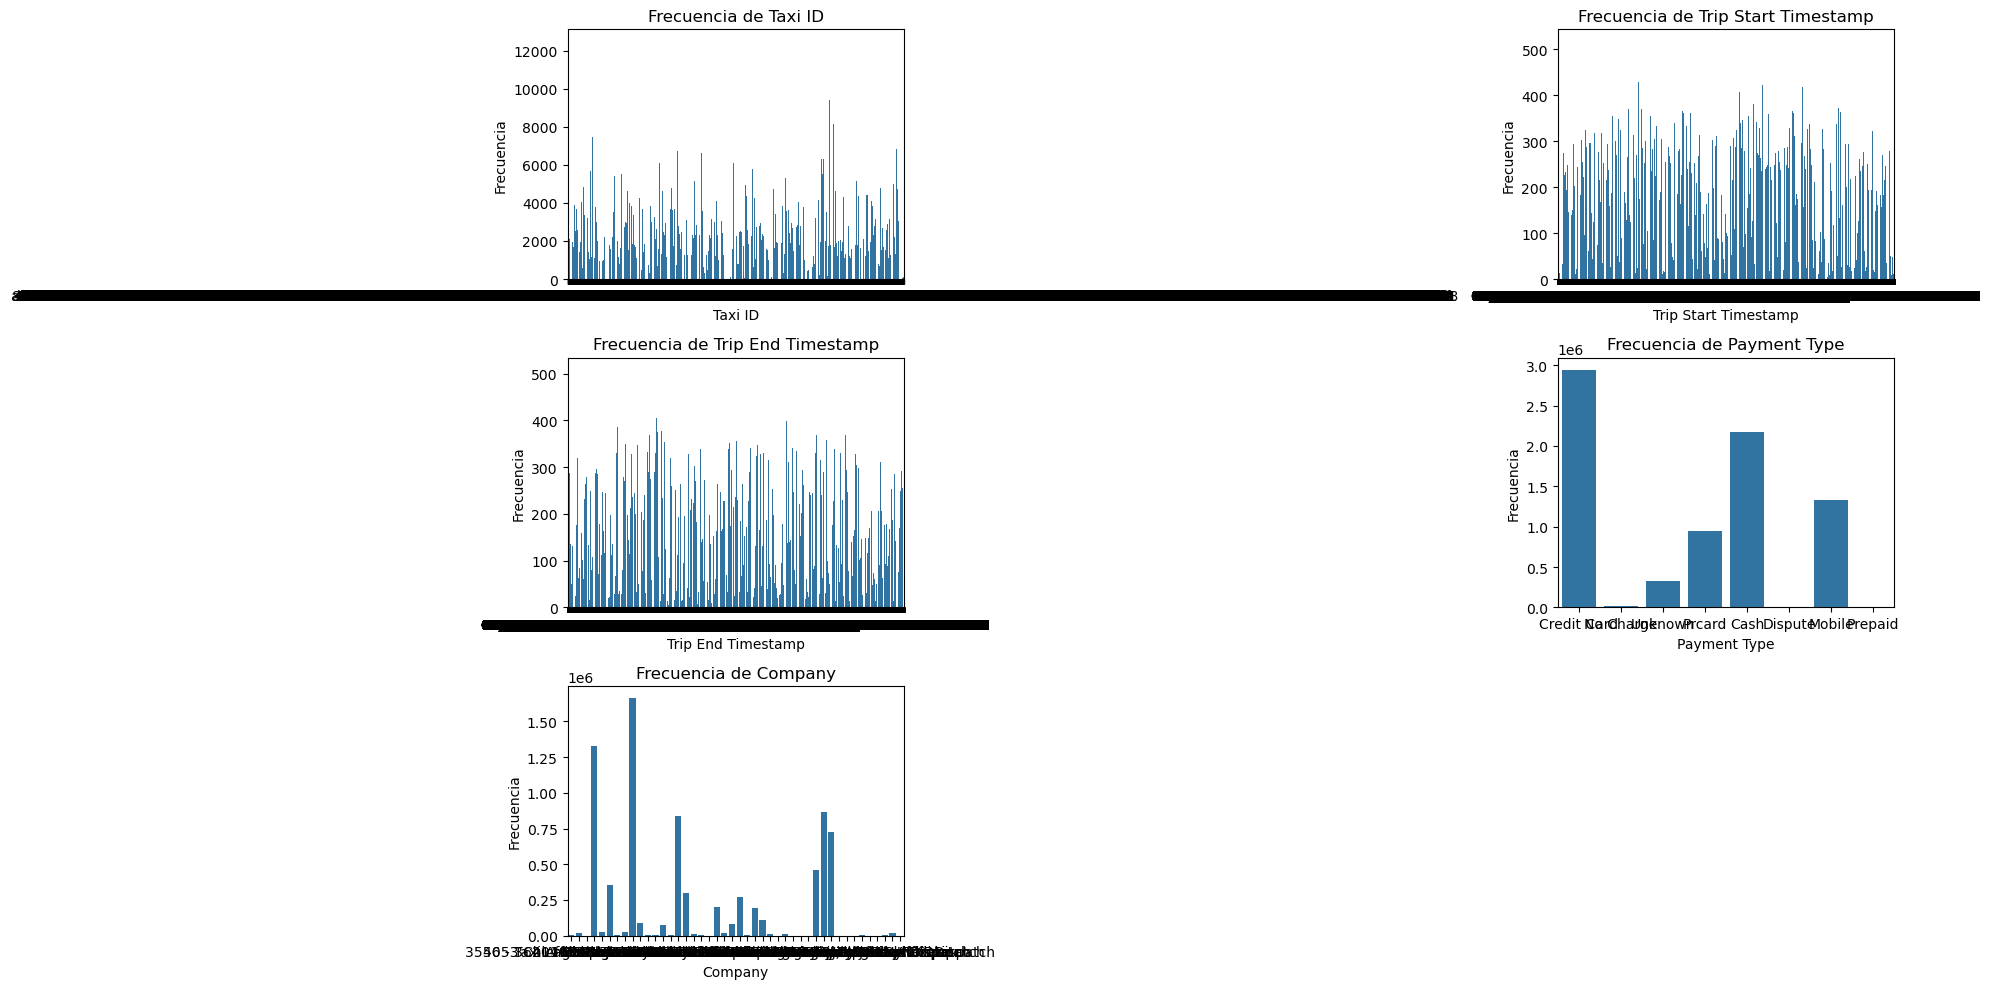

In [46]:
# Visualización de los valores de las columnas categóricas
plt.figure(figsize=(20, 10))

for i, column in enumerate(categoric_cols_selected, 1):
    plt.subplot(3, 2, i)
    # Contar las frecuencias de cada categoría
    df_filtered = clean_df.select(column).dropna()  # Eliminar valores nulos
    value_counts = df_filtered.groupBy(column).count().toPandas()

    # Gráfico de barras para cada columna
    sns.barplot(x=column, y="count", data=value_counts)
    plt.title(f"Frecuencia de {column}")
    plt.xlabel(column)
    plt.ylabel("Frecuencia")

plt.tight_layout()
plt.show()

# Análisis de Caracterización

In [47]:
def analizar_variables_numericas(df, columnas):
    resultados = []

    for columna in columnas:
        df_col = df.select(columna).dropna()

        total_count = df.select(columna).count()
        non_null_count = df_col.count()
        null_count = total_count - non_null_count

        resumen = df_col.select(
            mean(columna).alias("media"),
            stddev(columna).alias("stddev"),
            min(columna).alias("min"),
            max(columna).alias("max")
        ).first()

        percentiles = df_col.approxQuantile(columna, [0.01, 0.25, 0.5, 0.75, 0.99], 0.01)
        p1, q1, q2, q3, p99 = percentiles

        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        outliers_count = df_col.filter((col(columna) < lower_bound) | (col(columna) > upper_bound)).count()

        resultados.append((
            columna,
            int(total_count),
            int(null_count),
            float(resumen["media"]) if resumen["media"] is not None else None,
            float(resumen["stddev"]) if resumen["stddev"] is not None else None,
            float(resumen["min"]),
            float(q1),
            float(q2),
            float(q3),
            float(resumen["max"]),
            float(p1),
            float(p99),
            float(iqr),
            int(outliers_count)
        ))

    schema = StructType([
        StructField("Variable", StringType(), True),
        StructField("Total", LongType(), True),
        StructField("Nulos", LongType(), True),
        StructField("Media", DoubleType(), True),
        StructField("StdDev", DoubleType(), True),
        StructField("Min", DoubleType(), True),
        StructField("Q1", DoubleType(), True),
        StructField("Q2", DoubleType(), True),
        StructField("Q3", DoubleType(), True),
        StructField("Max", DoubleType(), True),
        StructField("P1", DoubleType(), True),
        StructField("P99", DoubleType(), True),
        StructField("IQR", DoubleType(), True),
        StructField("Outliers", LongType(), True),
    ])

    return spark.createDataFrame(resultados, schema=schema)

In [48]:
def analizar_variables_categoricas(df, columnas, umbral_rareza=0.01):
    resultados = []

    total_rows = df.count()

    for columna in columnas:
        df_col = df.select(columna)
        nulos = df_col.filter(col(columna).isNull() | isnan(col(columna))).count()

        # Conteo de valores por categoría
        conteo = df_col.groupBy(columna).count()

        # Número de valores únicos
        valores_unicos = conteo.count()

        # Top categoría
        top_row = conteo.orderBy(desc("count")).first()
        top_valor = top_row[columna] if top_row else None
        top_freq = top_row["count"] if top_row else 0
        top_pct = round((top_freq / total_rows) * 100, 2) if total_rows else 0

        # Rarezas: categorías con frecuencia <= umbral (por default ≤1%)
        rarezas = conteo.filter((col("count") / total_rows) <= umbral_rareza).count()

        resultados.append(Row(
            Variable=columna,
            Total=total_rows,
            Nulos=nulos,
            ValoresUnicos=valores_unicos,
            TopCategoria=top_valor,
            FrecuenciaTop=top_freq,
            PorcentajeTop=top_pct,
            Rarezas=rarezas
        ))

    return spark.createDataFrame(resultados)

In [49]:
prettyDisplay(analizar_variables_numericas(clean_df, numeric_cols_selected))

,Variable,Total,Nulos,Media,StdDev,Min,Q1,Q2,Q3,Max,P1,P99,IQR,Outliers
0,Trip Seconds,7740477,803,1225.386318,1579.873056,0.0,479.00,914.00,1668.00,86396.00,0.0,86396.00,1189.00,269099
1,Trip Miles,7740477,40,6.471484,6.987135,0.0,1.02,3.18,11.63,3397.80,0.0,3397.80,10.61,17772
2,Pickup Community Area,7740477,211818,35.545694,26.073060,1.0,8.00,32.00,56.00,77.00,1.0,77.00,48.00,0
3,Dropoff Community Area,7740477,639366,26.135820,20.695290,1.0,8.00,28.00,32.00,77.00,1.0,77.00,24.00,622169
4,Fare,7740477,0,21.548784,15.898695,0.0,8.25,15.25,33.25,85.07,0.0,85.07,25.00,26068
5,Tips,7740477,0,2.714085,3.821942,0.0,0.00,0.01,4.00,80.00,0.0,80.00,4.00,494317
6,Extras,7740477,0,1.700857,4.436027,0.0,0.00,0.00,2.00,85.00,0.0,85.00,2.00,429149
7,Trip Total,7740477,0,26.178352,19.902669,0.0,10.25,18.25,39.96,85.12,0.0,85.12,29.71,6566


In [50]:
prettyDisplay(analizar_variables_categoricas(clean_df, categoric_cols_selected))

,Variable,Total,Nulos,ValoresUnicos,TopCategoria,FrecuenciaTop,PorcentajeTop,Rarezas
0,Taxi ID,7740477,0,3409,d40dae7ea46d61abca67eb53b157fe9cf0b485cca6dce1...,12494,0.16,3409
1,Trip Start Timestamp,7740477,0,43769,12/12/2024 06:15:00 PM,517,0.01,43769
2,Trip End Timestamp,7740477,66,43783,10/17/2024 06:30:00 PM,509,0.01,43783
3,Payment Type,7740477,0,8,Credit Card,2945898,38.06,3
4,Company,7740477,0,44,Flash Cab,1664168,21.50,30


In [51]:
for col in numeric_cols_selected:
    corr = clean_df.stat.corr("Tips", col)
    print(f"Correlación entre Tips y {col}: {corr}")

Correlación entre Tips y Trip Seconds: 0.23933148506929539


Correlación entre Tips y Trip Miles: 0.43929402272176116


Correlación entre Tips y Pickup Community Area: 0.40452129162867256


Correlación entre Tips y Dropoff Community Area: -0.006721901883727382


Correlación entre Tips y Fare: 0.5039850051069042


Correlación entre Tips y Tips: 1.0


Correlación entre Tips y Extras: 0.33210969259307677


[Stage 961:===================================>                   (16 + 8) / 25]

Correlación entre Tips y Trip Total: 0.6755026391665814


### Propuesta de Binnings

| Variable                 | Rango / Bin                            | Etiqueta sugerida                       |
|--------------------------|----------------------------------------|-----------------------------------------|
| Trip Seconds             | 0–300, 301–900, 901–1800, >1800        | Muy corto, corto, medio, largo          |
| Trip Miles               | 0–2, 2–5, 5–10, >10                    | Muy corto, corto, medio, largo          |
| Pickup Community Area    | 1–20, 21–40, 41–60, 61–77              | Zona baja, media-baja, media-alta, alta |
| Dropoff Community Area   | 1–20, 21–40, 41–60, 61–77              | Zona baja, media-baja, media-alta, alta |
| Fare                     | 0–10, 10–20, 20–40, >40                | Muy baja, baja, media, alta             |
| Tips                     | 0–1, 1–2, 2–4, >4                      | Sin propina, baja, media, alta          |
| Extras                   | 0, 0.01–1, 1–4, >4                     | Ninguno, bajo, medio, alto              |
| Trip Total               | 0–15, 15–30, 30–60, >60                | Muy barato, barato, normal, costoso     |



# Tabla de caracterización sugerida

| Variable                   | Dominio                          | Estadísticas                 | Comentarios Relevantes                                      |
|----------------------------|-----------------------------------|------------------------------|-------------------------------------------------------------|
| Payment Type              | 8 valores únicos (ej. Credit Card) | 38% usa tarjeta               | Buen discriminador, refleja comportamiento de pago          |
| Company                   | 44 compañías                      | Top 5 concentran ~80%         | Se puede agrupar las raras para evitar ruido                |
| Trip Miles                | Rango 0–3397 (sin outliers hasta 20) | Media 6.47, IQR 10.61         | Se sugiere binning en 4 niveles                             |
| Trip Total                | Rango 0–9999 (sin outliers hasta ~80) | Media 26.18, IQR 29.71        | Refleja nivel de gasto; correlaciona con `Tips`             |
| Dropoff Community Area    | 77 zonas posibles (enteros)        | Media 26.13, IQR 24           | Representa ubicación destino, puede agruparse por regiones  |


# Particionamiento sugerido

Ya con las variables caracterizadas, ahora se definen las combinaciones de particiones. Supón que tomamos:

- `Payment Type` con 2 valores representativos: Credit Card, Cash (otros agrupados como "Otro")

- `Trip Total` con 4 bins

- `Company` agrupada en: Top 5, Medianas, Otras

Total de combinaciones:
3 Payment Type × 4 Trip Total × 3 Company = `36 combinaciones`